# <a href="https://ramp.studio/">RAMP</a> on detecting Type 2 Diabetes in a non-invasive fashion

_Authors:_
- AMANI Alexandre
- BISCARRAT Lilian
- CHAUSSARD Alexandre
- CLERGUE Eva
- NORMAND Sophie
- SALEMBIEN Tom

## Introduction

Diabetes is a growing disease, affecting over 10% of the worldwide population. The vast majority of diabetics are type 2 diabetics (96%), that is generally characterized by a resistance to insulin, which is a molecule that enables glucose to enter the cells and provide energy. Not being able to properly consume sugar results in several complications that are all tied up to the high sugar level concentration in the blood due to not being able to consume it, resulting in possible blindness, hearth disease, infections, and so on.

Therefore, it is one today's most important challenge to properly diagnose diabetics, as short as possible to prevent complications to settle. At the moment, diabetes is diagnosed in multiple ways, one of the most secure and proper one being HbA1c measurement from blood samples. The measurement of HbA1c for a sain individual is around 5.7%, while it is said to be diabetic-like when it reaches 6.5% and more.

While this technique has proved to be really efficient in the diagnosis, it has two main downsides that we would like to tackle in this study:
- First, HbA1c is a post-disease settlement indicator, as it requires the patient to have abnormally high sugar levels over 3 months to be indicating the disease. One would rather like to be able to diagnose diabetes before it reaches that critical point.
- Second, HbA1c being a blood measurement, which is naturally invasive for the patient and some may even be really reluctant and refuse to go for a diagnosis. Also, it requires careful analysis in a medical lab, which obviously costs money.

As a result, the goal of our study is to provide a machine learning algorithm that is able to predict whether or not somebody may become diabetic in the coming time, based on blood glucose measurements from a non-invasive Continuous Glucose Monitor (CGM), as well as gathered clinical data for the patient over the duration of the study.

(explain what are the features -not too much detail, we got deeper after-, what's the CGM thingy, what's iPro, framework of the study, link to the paper, etc...)

## Getting started with the RAMP starting kit

### Software prerequisites

This starting kit requires the following dependencies:
- numpy
- pandas
- scikit-learn
- matplolib
- jupyter


### Getting the data

The data are available in the `data` source folder.

### Explore the dataset

#### Clinical data

We start with an inspection of the training data set. These are only the clinical data, then we will dive into the CGM ones.

In [1]:
from problem import get_train_data, get_test_data
import pandas as pd
import seaborn as sns

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

print(f"Number of DT2 diagnosed patients in the training set: {str(y_train.sum()/len(y_train) * 100)[0]}/{len(y_train)}")
print(f"Number of DT2 diagnosed patients in the test set: {str(y_test.sum()/len(y_test) * 100)[0]}/{len(y_test)}")

Number of DT2 diagnosed patients in the training set: 7/139
Number of DT2 diagnosed patients in the test set: 8/69


In [2]:
X_train.head()

,gender,age,BMI,glycaemia
57,1.0,62.0,34.9,84.0
201,0.0,70.0,27.9,111.0
56,0.0,46.0,41.1,120.0
76,0.0,38.0,34.0,98.0
19,1.0,59.0,32.2,89.0


Explain the data features here

Looking at the gender distribution (...)

In [3]:
X_train["gender"].value_counts()

1.0    72
0.0    67
Name: gender, dtype: int64

In [4]:
X_train.isna().sum()

gender       0
age          0
BMI          1
glycaemia    0
dtype: int64

### BIM

We impute the missing value of the feature BIM by the average BIM of individuals of the same age and gender. 


In [5]:
X_train[(X_train["age"]==72) & (X_train["gender"]==1)]

,gender,age,BMI,glycaemia
91,1.0,72.0,NaN,96.0
148,1.0,72.0,29.0,105.0
9,1.0,72.0,35.6,106.0


In [6]:
df = X_train[(X_train["age"]==72) & (X_train["gender"]==1)]
X_train = X_train.fillna(value={"BMI":df["BMI"].mean()})
X_train.isna().sum()

gender       0
age          0
BMI          0
glycaemia    0
dtype: int64

etc...

##### Focus on the HbA1c

The typical diagnosis of diabetes is done through HbA1c blood measurement, which characterizes the glucose value over 3 month. The threshold of 6.5% characterizes diabetic people according to... blablabla

One can import the HbA1c measurements of the individual in our dataset. A statistical study is then proceeded.

In [7]:
from problem import get_HbA1c_and_labels_data

df_hba1c = get_HbA1c_and_labels_data()
df_hba1c.head()

,HbA1c,T2DM
1,6.3,False
2,5.8,False
3,5.5,False
4,6.0,False
5,5.2,False


**Correlation between HbA1c and T2DM**

In [8]:
df_hba1c["HbA1c"].corr(df_hba1c["T2DM"])

0.292815286786246

<AxesSubplot: xlabel='T2DM', ylabel='HbA1c'>

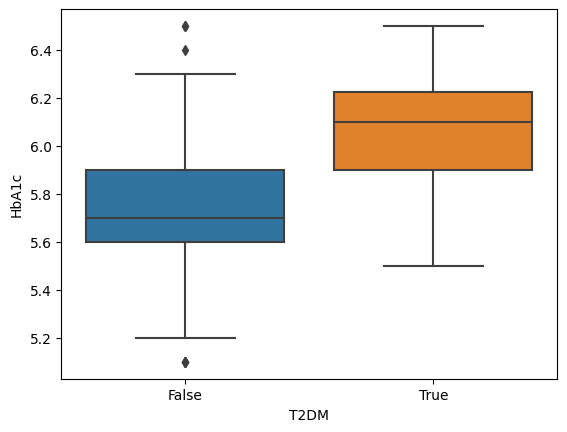

In [9]:
sns.boxplot(data=df_hba1c, x="T2DM", y = "HbA1c")

<AxesSubplot: xlabel='HbA1c', ylabel='Count'>

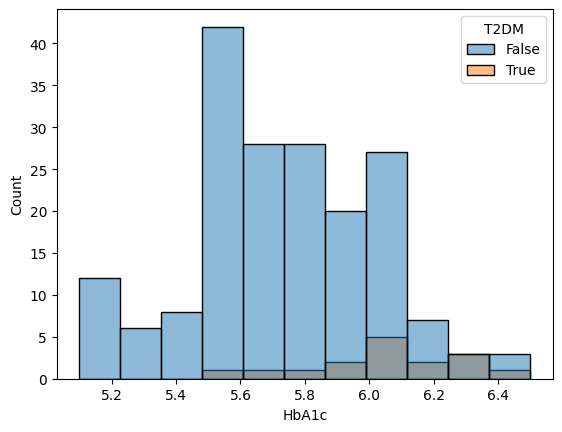

In [10]:
sns.histplot(data=df_hba1c, hue="T2DM", x = "HbA1c")

#### CGM Data

Now, we dive into the glucose monitored data. These are taken by the CGM iPro sensor (see link, blablabla).

Let's import one of the users CGM data so we can have a look.

In [11]:
import matplotlib.pyplot as plt
from problem import get_cgm_data

cgm_data = get_cgm_data(1)

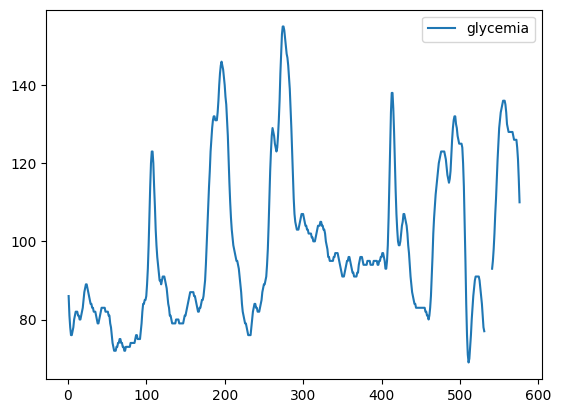

In [12]:
def plot_cgm_data(cgm_data):
    fig, axs = plt.subplots()
    axs.plot(cgm_data.index, cgm_data["glycemia"], label="glycemia")
    axs.legend()
    
plot_cgm_data(cgm_data)

**Interpolation of the Glucose (CGM data)**

Interpolation is a method used to estimate missing CGM data by predicting values that would have been recorded if the sensor had not failed.

There are several methods for interpolation of missing CGM data, but the choice of method depends on the nature of the data and the goals of the analysis. For our application, we use teh Linear interpolation method.This method estimates missing values by connecting the neighboring observed values with a straight line. It assumes that the glucose values change linearly over time.

Some other commonly used interpolation methods are:

- The cubic spline interpolation: This method estimates missing values by fitting a smooth curve to the observed data using cubic polynomials. Cubic spline interpolation assumes that the glucose values change smoothly over time.

- The Kalman filter: This method estimates missing values by using a mathematical model that predicts the glucose values based on the observed data and the known properties of the system. Kalman filter interpolation assumes that the glucose values follow a stochastic process. This method has been widely in used recently to interpolate Glucose data.


In [13]:
cgm_data_interp = cgm_data.interpolate(method="linear")

<AxesSubplot: >

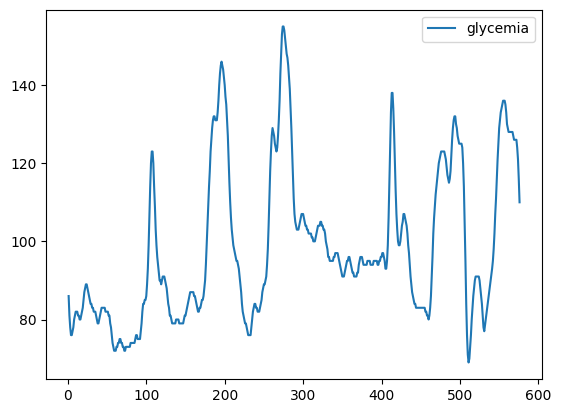

In [14]:
cgm_data_interp.plot()

In [15]:
def interpolate_cgm(cgm_data, method="linear"):
    return cgm_data.interpolate(method=method)

What we might be interested in is the time in the normal range over the whole time serie, the overall variance, maximum values of the glycemia for instance. So to that end, we will interpolate the missing values to determine the following features:
- Average time in range (time spent in the normal range (70 - 127) over the whole time serie)
- Maximum value of the time serie
- Overall variance of the data
- Average glucose value

In [7]:
def compute_variance(cgm_data):
    return cgm_data["glycemia"].var()

def compute_mean(cgm_data):
    return cgm_data["glycemia"].mean()

def compute_average_time_in_range(cgm_data, normal_range=[70, 127]):
    index_in_range = cgm_data[(cgm_data["glycemia"] >= 70) & (cgm_data["glycemia"] <= 127)].index
    return len(index_in_range)/len(cgm_data.index)

def compute_maximum(cgm_data):
    return cgm_data["glycemia"].max()

variance = compute_variance(cgm_data)
mean_value = compute_mean(cgm_data)
avg_time_in_range = compute_average_time_in_range(cgm_data, normal_range=[70, 127])
maximum_value = compute_maximum(cgm_data)

print(f"Extracted features: " +
      f"\n- Variance: {variance}" +
      f"\n- Mean: {mean_value} " +
      f"\n- Average time in range {str(avg_time_in_range*100)[0:5]}% " +
      f"\n- Maximum: {maximum_value}")

Extracted features: 
- Variance: 385.6137850241557
- Mean: 98.42013888888889 
- Average time in range 88.02% 
- Maximum: 155.0


These new features regarding the patients are part of the data exploration we can do on the CGM time series, to finally determine whether the patient is going to be DT2 or not in addition to the clinical data.

Other suggestions could be implemented: looking at postprandial overall values (that would use more of the time serie structure), night mean value, day mean value, day variance, etc...

##### Some statistical insights on the CGM data

One can import all the CGM data using the following code snippet

In [11]:
from problem import get_24h_cgm_data
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

cgm_24h = get_24h_cgm_data(user_id_list=[i for i in range(1, 208)])
cgm_24h.head()

,00:00,00:05,00:10,00:15,00:20,00:25,00:30,00:35,00:40,00:45,...,23:10,23:15,23:20,23:25,23:30,23:35,23:40,23:45,23:50,23:55
1_1,86.0,81.0,78.0,76.0,76.0,77.0,78.0,80.0,81.0,82.0,...,148.0,147.0,145.0,142.0,139.0,134.0,129.0,123.0,117.0,111.0
1_2,107.0,105.0,104.0,103.0,103.0,103.0,104.0,105.0,106.0,107.0,...,128.0,127.0,126.0,126.0,126.0,126.0,124.0,121.0,116.0,110.0
2_1,167.0,163.0,158.0,151.0,144.0,137.0,132.0,127.0,125.0,125.0,...,108.0,106.0,103.0,100.0,97.0,95.0,94.0,95.0,97.0,99.0
2_2,101.0,103.0,104.0,105.0,105.0,104.0,102.0,101.0,99.0,97.0,...,129.0,129.0,129.0,129.0,129.0,130.0,130.0,131.0,132.0,133.0
3_1,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,89.0,88.0,...,101.0,100.0,100.0,101.0,101.0,102.0,103.0,104.0,104.0,104.0


### Building predictive models

For submitting to the [RAMP site](https://ramp.studio), you will need to create a `estimator.py` file that defines a `get_estimator` function which returns a scikit-learn estimator.

The initial example classifier in your sandbox is:

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def get_estimator():
    clf = RandomForestClassifier(
        n_estimators=5, max_depth=5, random_state=61
    )
    return clf

When developing locally, you can use `scikit-learn` tools to test a given model.

In [ ]:
from sklearn.model_selection import cross_val_score
from problem import get_cv

cv = get_cv(X_train, y_train)
cross_val_score(get_estimator(), X_train, y_train, cv=cv)

You could easily train an test a model and the respective datasets.

In [ ]:
model = get_estimator()
model.fit(X_train, y_train)
model.score(X_test, y_test)

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)